# EE 519 — Frequency-domain Analysis of Speech (Lecture 7)
## Notebook — Windowing and Spectral Leakage (with speech clips)

**New requirement for Lecture 7 workflow:** Use your saved clips from Notebook 7.0.

---
## What you will do
1. Visualize common windows and frequency responses.
2. Demonstrate leakage with a controlled tone.
3. Apply windowing to **selected speech frames** (voiced vowel).
4. Save key plots so you can reuse them in your write-up.

> Many confusing STFT artifacts come from **leakage**. This notebook makes that concrete.


### How to use Lecture 7 notebooks in-class (hands-on)
**Goal:** build intuition for STFT by repeatedly analyzing *your own* recordings under different window/hop choices.

**Workflow for the whole lecture**
1. Record multiple clips once (Notebook 7.0) and they are saved + registered in a manifest.
2. Every later notebook reuses the same recordings (no re-recording needed).
3. Always pick **meaningful time regions** (vowel middle, fricative middle, stop burst, silence) — not just the first frames.

**Where things are saved**
- Audio: `EE519_L7_Project/audio/`
- Figures: `EE519_L7_Project/figures/`
- Manifest: `EE519_L7_Project/manifest.json`

**Pro tip:** keep filenames consistent across the class:  
`vowel_a_soft`, `vowel_a_loud`, `sentence_fast`, `sentence_slow`, `fricative_s`, `stop_pa`, `silence_room`


### ✅ Clip checklist (quick self-check)
By the end of Notebook 7.0 you should have **at least 8 clips** registered in your manifest:

**Required categories**
- **Vowel**: one steady vowel (e.g., /a/ or /i/) — *soft* and *loud*
- **Sentence**: one short sentence — *slow* and *fast*
- **Fricative**: sustained /s/ or /sh/
- **Stop**: repeated /pa pa pa/ or /ta ta ta/ (captures bursts + closures)
- **Silence**: 2–3 seconds of room silence

If you're missing any, record them now in 7.0 (it takes 2 minutes and makes later analysis much clearer).


## 0) Setup
(Uses the same project folders: `EE519_L7_Project/`.)


#### 🎙️ Before you record: tips for clean data
- Sit ~15–25 cm from the mic.
- Avoid tapping the laptop/desk (low-frequency thumps).
- Record at least **2–3 seconds** per clip.
- For vowel: hold a steady pitch (don’t glide).
- For sentence: keep content the same across slow/fast versions.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


In [1]:
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import get_window, chirp
from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

# ---------------------------
# Project folders (auto-create)
# ---------------------------
PROJECT_DIR = Path("EE519_L7_Project")
AUDIO_DIR   = PROJECT_DIR / "audio"
FIG_DIR     = PROJECT_DIR / "figures"
RESULTS_DIR = PROJECT_DIR / "results"
for d in [PROJECT_DIR, AUDIO_DIR, FIG_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def _to_float_mono(y):
    """Convert audio array to float32 mono in [-1, 1]."""
    y = np.asarray(y)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.float32) / (np.iinfo(y.dtype).max + 1e-12)
    else:
        y = y.astype(np.float32)
    mx = np.max(np.abs(y)) + 1e-12
    if mx > 1.0:
        y = y / mx
    return y

def load_wav(path):
    fs, y = wavfile.read(path)
    return fs, _to_float_mono(y)

def save_wav(path, fs, y):
    """Save float audio in [-1,1] to 16-bit PCM WAV."""
    y16 = np.clip(y, -1.0, 1.0)
    y16 = (y16 * 32767).astype(np.int16)
    wavfile.write(str(path), fs, y16)

def play_audio(y, fs, label=None):
    if label:
        print(label)
    display(Audio(y, rate=fs))

def plot_waveform(y, fs, title="Waveform", tlim=None, save_as=None):
    t = np.arange(len(y)) / fs
    plt.figure(figsize=(12, 3))
    plt.plot(t, y, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def mag_spectrum(y, fs, nfft=None, db=True):
    y = np.asarray(y, dtype=np.float32)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(len(y))))
    Y = fft(y, n=nfft)
    f = fftfreq(nfft, d=1/fs)
    idx = f >= 0
    mag = np.abs(Y[idx])
    if db:
        mag = 20*np.log10(mag + 1e-10)
    return f[idx], mag

def plot_spectrum(y, fs, title="Magnitude Spectrum", fmax=None, nfft=None, db=True, save_as=None):
    f, mag = mag_spectrum(y, fs, nfft=nfft, db=db)
    plt.figure(figsize=(12, 3))
    plt.plot(f, mag, linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)" if db else "Magnitude")
    plt.title(title)
    if fmax is not None:
        plt.xlim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def rms(y):
    y = np.asarray(y, dtype=np.float32)
    return float(np.sqrt(np.mean(y**2) + 1e-12))

def add_white_noise(y, snr_db, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, dtype=np.float32)
    sig_pwr = np.mean(y**2) + 1e-12
    noise_pwr = sig_pwr / (10**(snr_db/10))
    noise = rng.standard_normal(len(y), dtype=np.float32) * np.sqrt(noise_pwr)
    return y + noise

def select_segment(y, fs, start_s, end_s):
    s = int(start_s*fs); e = int(end_s*fs)
    s = max(0, min(s, len(y)))
    e = max(0, min(e, len(y)))
    if e <= s:
        raise ValueError("end_s must be > start_s and within signal duration.")
    return y[s:e]

# ---------------------------
# Recording utilities
# ---------------------------
SOUNDDEVICE_OK = False
try:
    import sounddevice as sd
    SOUNDDEVICE_OK = True
except Exception:
    SOUNDDEVICE_OK = False

def record_audio(seconds=3.0, fs=16000, channels=1):
    if not SOUNDDEVICE_OK:
        raise RuntimeError("sounddevice not available. Upload WAVs or install sounddevice locally.")
    print(f"Recording {seconds:.1f}s at {fs} Hz... (speak now)")
    y = sd.rec(int(seconds*fs), samplerate=fs, channels=channels, dtype='float32')
    sd.wait()
    y = _to_float_mono(y)
    print("Done. RMS:", rms(y))
    return fs, y

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    return {"audio_clips": [], "notes": []}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2), encoding="utf-8")

def register_clip(name, path, fs, duration_s, tags=None, notes=""):
    m = load_manifest()
    m["audio_clips"].append({
        "name": name,
        "path": str(path),
        "fs": fs,
        "duration_s": float(duration_s),
        "tags": tags or [],
        "notes": notes
    })
    save_manifest(m)

def list_clips():
    m = load_manifest()
    if len(m["audio_clips"]) == 0:
        print("No clips registered yet.")
        return
    for i, c in enumerate(m["audio_clips"]):
        print(f"[{i}] {c['name']} | {c['duration_s']:.2f}s | fs={c['fs']} | tags={c['tags']} | file={c['path']}")


#### 🔧 Optional automated check (run anytime)
This cell reads your `manifest.json` and tells you what clip types you might be missing.


In [2]:
# Automated checklist (uses tags and/or names)
import json, re
from pathlib import Path

MANIFEST_PATH = Path("EE519_L7_Project/manifest.json")
if not MANIFEST_PATH.exists():
    print("No manifest found yet. Run Notebook 7.0 and record at least one clip.")
else:
    m = json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    clips = m.get("audio_clips", [])
    names = [c.get("name","").lower() for c in clips]
    tags  = [set([t.lower() for t in c.get("tags",[])]) for c in clips]

    def has(pattern):
        rgx = re.compile(pattern)
        return any(rgx.search(n) for n in names)

    def has_tag(t):
        return any(t in tg for tg in tags)

    req = {
        "vowel (soft)": has("vowel") and (has("soft") or has_tag("soft")),
        "vowel (loud)": has("vowel") and (has("loud") or has_tag("loud")),
        "sentence (slow)": has("sentence") and (has("slow") or has_tag("slow")),
        "sentence (fast)": has("sentence") and (has("fast") or has_tag("fast")),
        "fricative": has("fric") or has("s_") or has_tag("fricative"),
        "stop/burst": has("stop") or has("pa") or has("ta") or has_tag("stop"),
        "silence": has("silence") or has_tag("silence"),
    }

    print("Manifest clips:", len(clips))
    missing = [k for k,v in req.items() if not v]
    if not missing:
        print("✅ Looks good — you have the recommended set.")
    else:
        print("⚠️ Missing (recommended):")
        for k in missing:
            print(" -", k)


Manifest clips: 6
⚠️ Missing (recommended):
 - vowel (soft)
 - vowel (loud)
 - sentence (slow)
 - sentence (fast)
 - fricative
 - stop/burst
 - silence


---
## 1) Window shapes (time domain)
**Before running:** which window do you think causes the MOST leakage and why?


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved -> EE519_L7_Project/figures/L7_1_windows_time.png


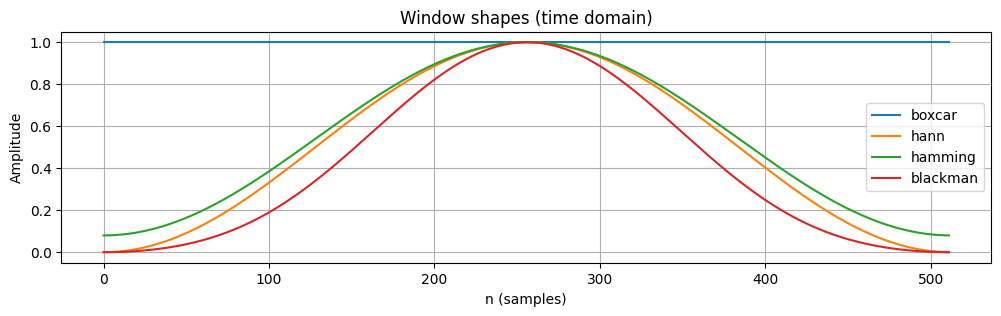

In [3]:
N = 512
win_names = ["boxcar", "hann", "hamming", "blackman"]
wins = {w: get_window(w, N, fftbins=True) for w in win_names}

plt.figure(figsize=(12, 3))
for w in win_names:
    plt.plot(wins[w], label=w)
plt.title("Window shapes (time domain)")
plt.xlabel("n (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.savefig(FIG_DIR/"L7_1_windows_time.png", dpi=160, bbox_inches="tight")
print("Saved ->", FIG_DIR/"L7_1_windows_time.png")
plt.show()


---
## 2) Window magnitude response (mainlobe vs sidelobes)
Look for:
- narrower mainlobe = better frequency resolution
- lower sidelobes = less leakage


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved -> EE519_L7_Project/figures/L7_1_windows_freq.png


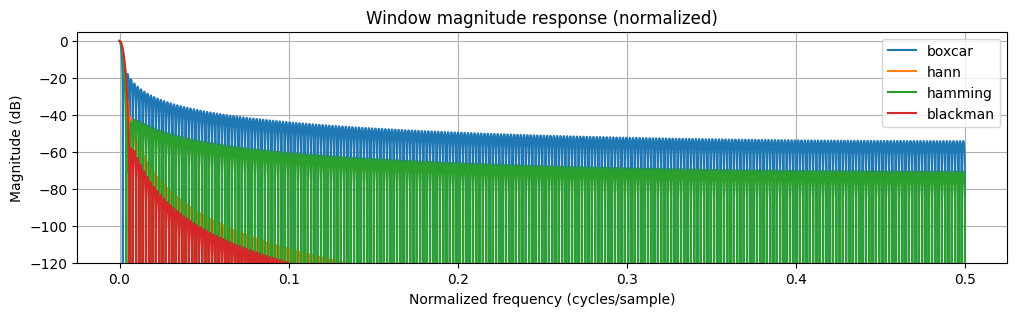

In [4]:
def window_response_db(w, nfft=16384):
    W = np.fft.rfft(w, n=nfft)
    mag = 20*np.log10(np.abs(W) + 1e-12)
    mag -= np.max(mag)
    f = np.fft.rfftfreq(nfft, d=1.0)  # normalized
    return f, mag

plt.figure(figsize=(12, 3))
for w in win_names:
    f, mag = window_response_db(wins[w], nfft=16384)
    plt.plot(f, mag, label=w)
plt.title("Window magnitude response (normalized)")
plt.xlabel("Normalized frequency (cycles/sample)")
plt.ylabel("Magnitude (dB)")
plt.ylim(-120, 5)
plt.legend()
plt.savefig(FIG_DIR/"L7_1_windows_freq.png", dpi=160, bbox_inches="tight")
print("Saved ->", FIG_DIR/"L7_1_windows_freq.png")
plt.show()


---
## 3) Leakage demo with bin-aligned vs misaligned sinusoid
This is the cleanest way to see leakage.

**Prediction:** leakage will be much worse when the tone is between bins.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved -> EE519_L7_Project/figures/L7_1_leakage_bin_aligned.png


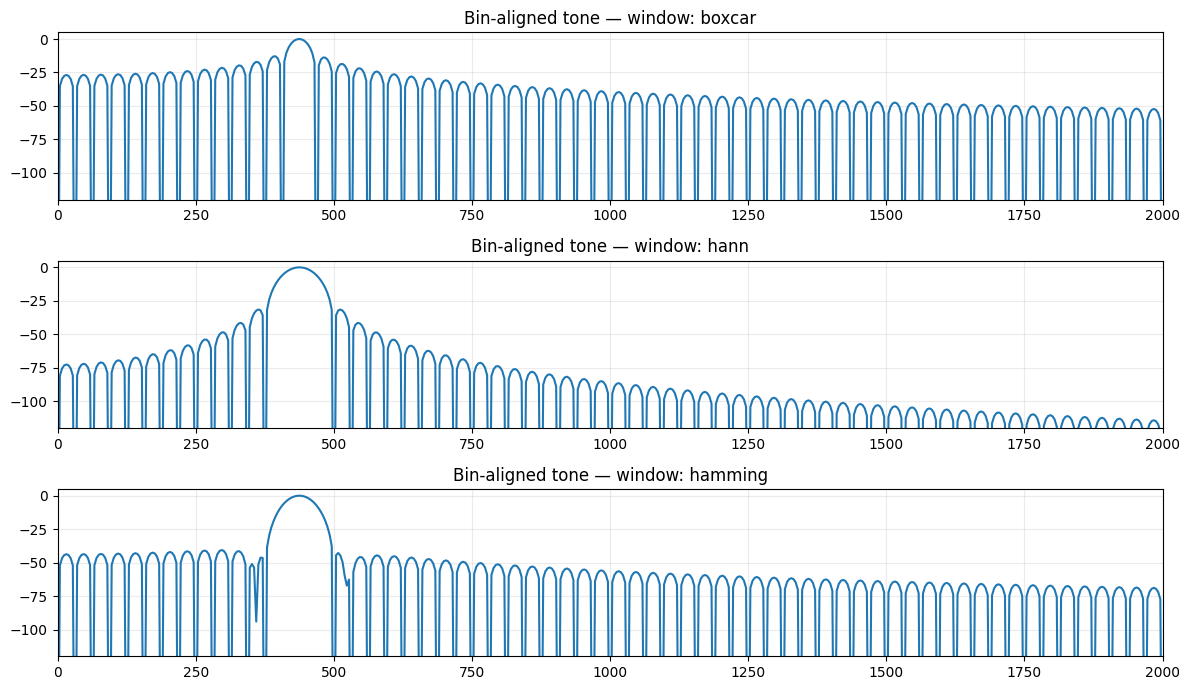

Saved -> EE519_L7_Project/figures/L7_1_leakage_misaligned.png


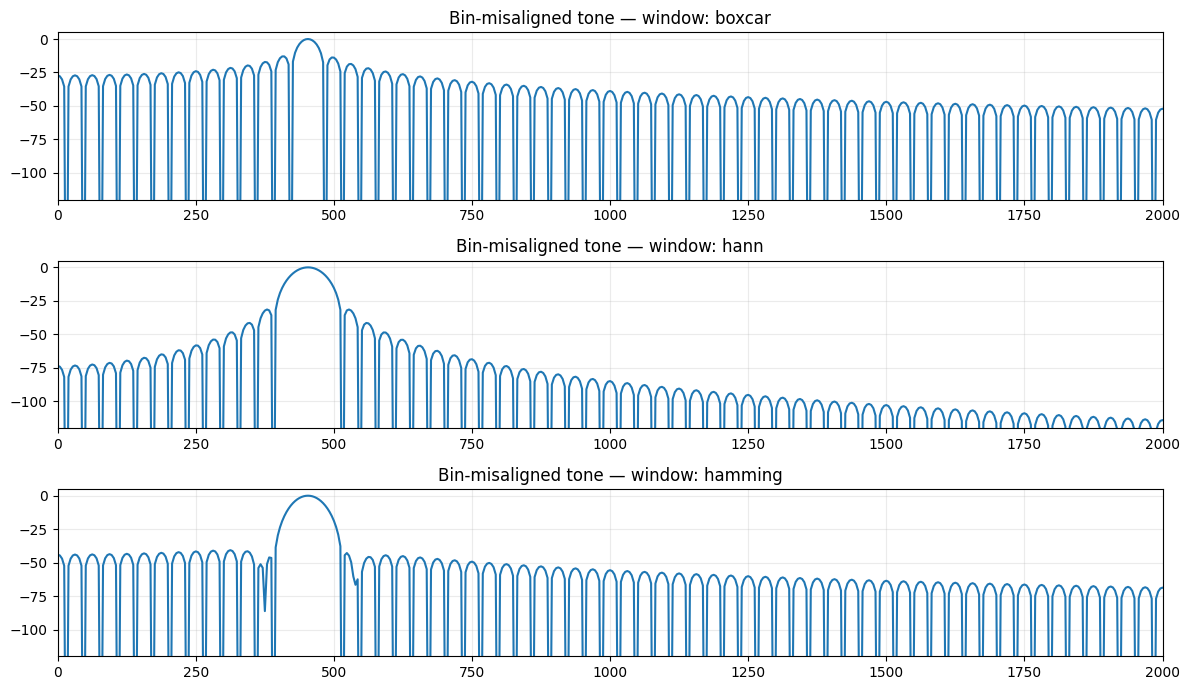

In [5]:
fs = 16000
N = 512
n = np.arange(N)

k0 = 14
f_bin  = k0 * fs / N
f_half = (k0 + 0.5) * fs / N

x_bin  = np.sin(2*np.pi*f_bin*n/fs)
x_half = np.sin(2*np.pi*f_half*n/fs)

def leakage_plot(x, label, save_as):
    plt.figure(figsize=(12, 7))
    for i, wname in enumerate(["boxcar", "hann", "hamming"]):
        w = get_window(wname, N, fftbins=True)
        X = np.fft.rfft(x*w, n=4096)
        f = np.fft.rfftfreq(4096, d=1/fs)
        mag = 20*np.log10(np.abs(X) + 1e-12); mag -= np.max(mag)
        plt.subplot(3,1,i+1)
        plt.plot(f, mag)
        plt.title(f"{label} — window: {wname}")
        plt.xlim(0, 2000); plt.ylim(-120, 5)
        plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.savefig(FIG_DIR/save_as, dpi=160, bbox_inches="tight")
    print("Saved ->", FIG_DIR/save_as)
    plt.show()

leakage_plot(x_bin,  "Bin-aligned tone",   "L7_1_leakage_bin_aligned.png")
leakage_plot(x_half, "Bin-misaligned tone","L7_1_leakage_misaligned.png")


---
## 4) Apply windowing to a *speech frame*
### Choose a voiced vowel clip
Select a vowel clip (from manifest) and choose a stable region.

**Goal:** observe how different windows change the spectral appearance of harmonics.


#### ✅ Checkpoint: choose clips you can explain
Pick clips where you can point to regions like:
- steady **vowel** (voiced)  
- sustained **/s/** (unvoiced)  
- **stop burst** (brief)  
- **silence/closure** (low energy)

**In-class goal:** you should be able to say “this region is voiced/unvoiced/stop/silence” *before* plotting.


[0] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[1] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[2] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[3] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[4] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[5] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
Using clip: vowel_a_normal | tags: ['voiced', 'vowel', 'normal']


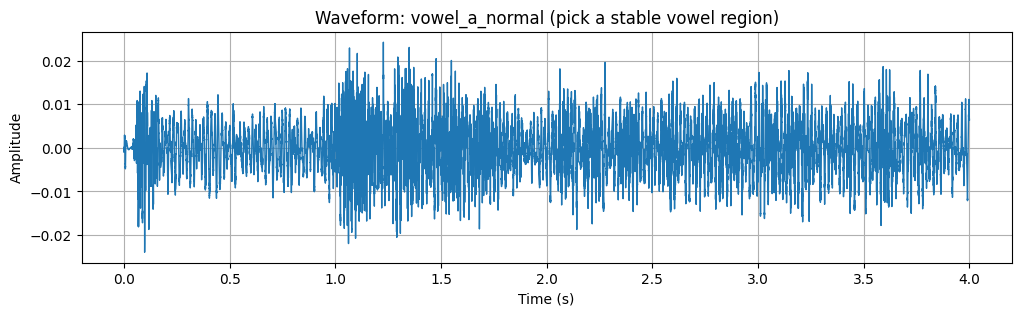

vowel_a_normal


In [6]:
list_clips()
clip_index = 0  # TODO: choose your vowel clip index

m = load_manifest()
if len(m["audio_clips"]) > clip_index:
    c = m["audio_clips"][clip_index]
    fs_s, y_s = load_wav(c["path"])
    print("Using clip:", c["name"], "| tags:", c["tags"])
    plot_waveform(y_s, fs_s, title=f"Waveform: {c['name']} (pick a stable vowel region)")
    play_audio(y_s, fs_s, label=c["name"])
else:
    print("No such clip index. Record/register clips first.")


### Pick a short segment (e.g., 20-30 ms) from the vowel/sentence
Set times after inspecting the waveform.

**Tip:** choose the middle of the vowel (avoid onset/offset).


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Segment duration (ms): 80.0
Selected vowel segment


Saved figure -> EE519_L7_Project/figures/L7_1_vowel_a_normal_segment.png


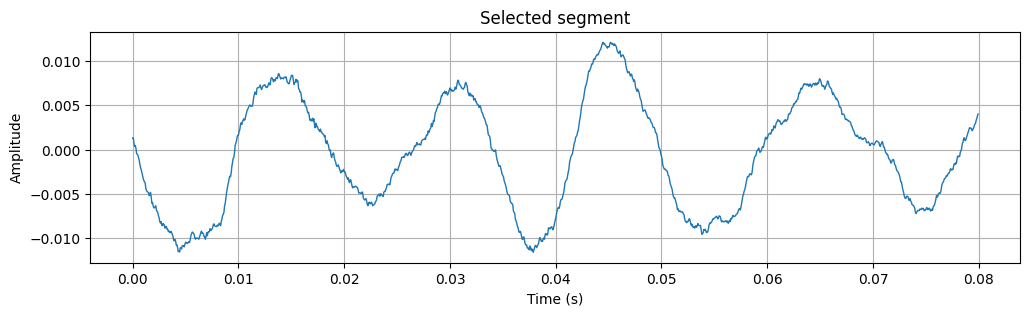

Saved figure -> EE519_L7_Project/figures/L7_1_vowel_a_normal_spec_boxcar.png


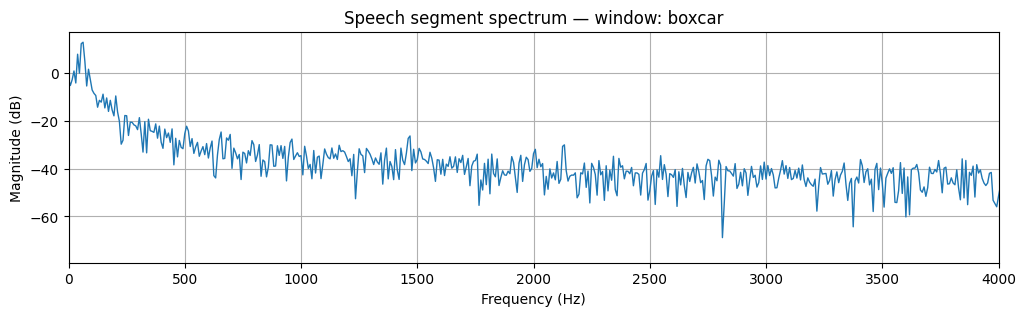

Saved figure -> EE519_L7_Project/figures/L7_1_vowel_a_normal_spec_hann.png


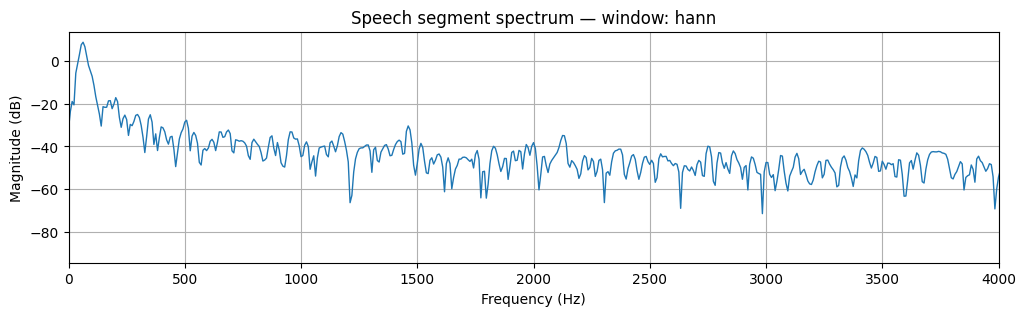

Saved figure -> EE519_L7_Project/figures/L7_1_vowel_a_normal_spec_hamming.png


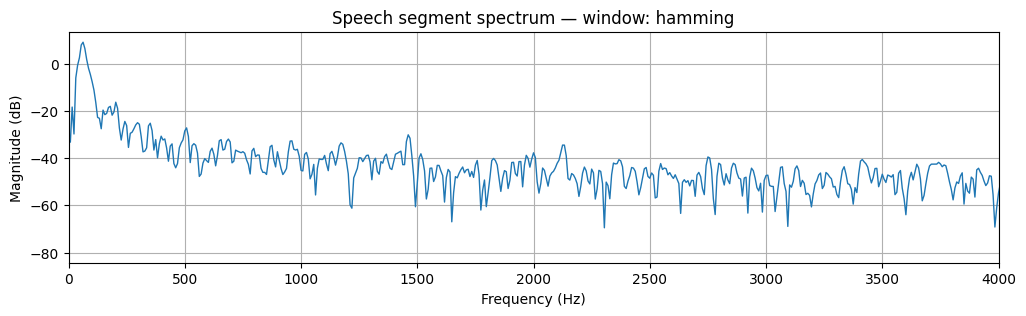

Saved figure -> EE519_L7_Project/figures/L7_1_vowel_a_normal_spec_blackman.png


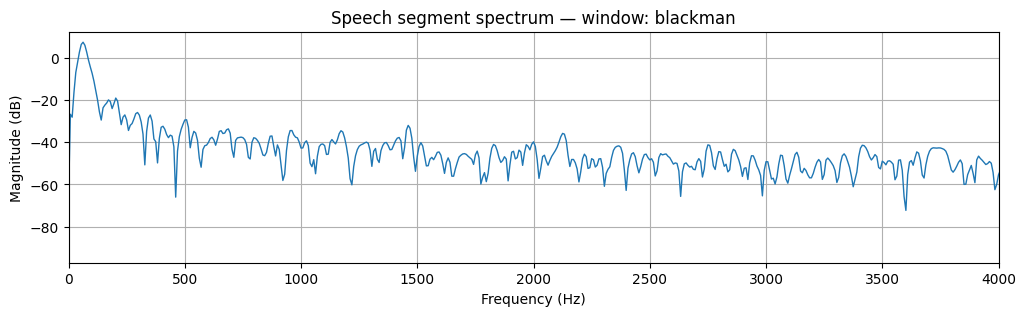

In [7]:
if "y_s" in globals():
    start_s, end_s = 0.4, 0.48  # TODO: adjust
    seg = select_segment(y_s, fs_s, start_s, end_s)
    print("Segment duration (ms):", 1000*len(seg)/fs_s)
    play_audio(seg, fs_s, label="Selected vowel segment")
    plot_waveform(seg, fs_s, title="Selected segment", save_as=f"L7_1_{c['name']}_segment.png")

    N = len(seg)
    for wname in ["boxcar", "hann", "hamming", "blackman"]:
        w = get_window(wname, N, fftbins=True)
        plot_spectrum(seg*w, fs_s,
                      title=f"Speech segment spectrum — window: {wname}",
                      fmax=min(4000, fs_s/2), db=True,
                      save_as=f"L7_1_{c['name']}_spec_{wname}.png")
else:
    print("No speech clip loaded.")


---
## Reflection + what you learned
1) Which window reduced leakage the most? How do you know?  
2) Which window preserved the sharpest harmonic peaks?  
3) For speech STFT, why might Hann/Hamming be a good default?  

### What’s next
Notebook: Build STFT (manual) and start spectrograms.


---
## ✅ End-of-notebook wrap-up
**1-minute reflection (write in sentences):**
- What parameter change produced the *biggest visible difference* today?
- Which plot helped you most: waveform, spectrum, etc — and why?
- Which types of sshor segment ignals (vowels at different loudness levels—soft vs. loud; a short sentence spoken slowly and quickly; sustained fricatives such as /s/ or /ʃ/; and repeated stop consonants such as /pa pa pa/ or /ta ta ta/) reflect which speech properties, and why?

- Name one mistake you made (or could make) and how you would debug it.

**What’s next:** proceed to the next Lecture notebook and reuse the same saved recordings.
